### 1. Importing Essential Libraries

This first cell imports all the necessary tools and libraries we'll need for our project.

* `torch`, `torch.nn`, and `torch.optim`: These are the core PyTorch libraries. We use them to build our neural network (`nn`), define the loss function, and choose an optimizer (`optim`) that updates our model to make it more accurate.
* `torch.utils.data`: This is used to create a `Dataset` and `DataLoader`, which are tools for efficiently loading and feeding our image data to the model in batches.
* `torchvision`: This is PyTorch's library for computer vision. We use it here to easily load the MNIST dataset (`datasets`) and to apply transformations to our images (`transforms`).
* `sklearn.model_selection`: We use `train_test_split` from this library to separate our training data into training and validation sets.
* `numpy` and `matplotlib.pyplot`: These are standard Python libraries. `numpy` is for numerical operations, and `matplotlib` is for plotting graphs, like our training results.
* `tqdm`: This is a helpful utility that will show us a visual progress bar during training.



In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm # For progress bars


### 2. Loading and Preparing the MNIST Dataset

This cell handles loading the famous MNIST dataset (which contains images of handwritten digits) and preparing it for our neural network.

* **Load Datasets:** First, we use `datasets.MNIST` to download (or find in the `./data` folder) the two parts of the dataset:
    * The **training set** (`train=True`), which has 60,000 images.
    * The **test set** (`train=False`), which has 10,000 images.
    * Notice `transform=None`. This is important. We're telling PyTorch *not* to apply any changes yet, because we want to handle the data preparation manually.

* **Combine Datasets:** We use `torch.cat` (which stands for "concatenate") to join the training and test sets together. This creates one large "pool" of 70,000 images (`all_data_tensor`) and their corresponding 70,000 labels (`all_targets_tensor`). We do this so we can create our own custom training, validation, and test splits later.

* **Manual Transformation (The Important Part):** We perform two critical steps on the combined image data:
    1.  **Normalization:** We convert the data to `.float()` and divide by `255.0`.  The original pixel values range from 0 (black) to 255 (white). This step scales all values to be between `0.0` and `1.0`. This is a standard practice that helps the model learn faster and more reliably.
    2.  **Add Channel Dimension:** We use `.unsqueeze(1)`. A Convolutional Neural Network (CNN) expects images to have a "channel" dimension (e.g., 3 channels for an RGB color image). Since MNIST images are grayscale, they only have **one channel**. This command adds that dimension, changing the data shape from `(70000, 28, 28)` to `(70000, 1, 28, 28)`.

* **Print Shapes:** The `print` statements are a "sanity check" to confirm that our data has the exact shape our model will expect.

In [21]:
# Load the 60,000 training images
train_dataset_full = datasets.MNIST(
    root='./data', 
    train=True, 
    download=True, # We have the files
    transform=None # No transform yet, we'll do it manually
)

# Load the 10,000 test images
test_dataset_full = datasets.MNIST(
    root='./data', 
    train=False, 
    download=True, # We have the files
    transform=None
)

# Combine them into one large dataset (70,000 images)
all_data_tensor = torch.cat((train_dataset_full.data, test_dataset_full.data), dim=0)
all_targets_tensor = torch.cat((train_dataset_full.targets, test_dataset_full.targets), dim=0)

# Manually normalize to [0, 1] and add the channel dimension
# CNNs expect: (Batch, Channels, Height, Width)
# We go from (70000, 28, 28) -> (70000, 1, 28, 28)
all_data_tensor = (all_data_tensor.float() / 255.0).unsqueeze(1)

print(f"Combined data shape: {all_data_tensor.shape}") # Should be [70000, 1, 28, 28]
print(f"Combined targets shape: {all_targets_tensor.shape}")

Combined data shape: torch.Size([70000, 1, 28, 28])
Combined targets shape: torch.Size([70000])


### 3. Creating Train, Validation, and Test Splits

Now that we have one large dataset, we need to split it into three separate sets. This is a standard and very important practice in machine learning:

* **Training Set (60%):** The largest set. The model *learns* by looking at these images and their labels.
* **Validation Set (20%):** Used *during* training. We "validate" the model's performance on this set after each epoch (training cycle) to see if it's improving and to check for **overfitting**.
* **Test Set (20%):** Kept separate until the very end. We only use this set *once* after all training is complete to get a final, unbiased score of our model's real-world performance.

---

Here's how we create this 60/20/20 split:

1.  **Convert to NumPy:** The `train_test_split` function from `sklearn` (a popular machine learning library) works best with NumPy arrays, so we use `.numpy()` to convert our tensors.

2.  **First Split (60% Train, 40% Temp):** We split the full 70,000-image dataset. We set `test_size=0.4` to pull out 40% for a temporary set, leaving the other 60% as our final `x_train` and `y_train`.

3.  **Second Split (20% Val, 20% Test):** We take the "temporary" 40% set and split it perfectly in half (`test_size=0.5`). This gives us two sets that are each 20% of the original total: our final `x_val`/`y_val` and `x_test`/`y_test`.

**Key Parameters Explained:**

* `stratify=...`: This is a critical command. It ensures that the distribution of digits (0-9) is **the same** in all three sets.  For example, it makes sure we don't accidentally put all the "5"s in the test set. This prevents bias.
* `random_state=42`: This ensures our split is **reproducible**. By setting a "random seed," we guarantee that every time we run this code, the *exact same* "random" split is created. This is essential for debugging and comparing results fairly.

The `print` statements at the end are a sanity check to confirm that our sets have the correct number of images.

In [22]:
# We need to use NumPy arrays for sklearn's split function
data_np = all_data_tensor.numpy()
targets_np = all_targets_tensor.numpy()

# 1. Split 60% train, 40% temp (for val + test)
x_train, x_temp, y_train, y_temp = train_test_split(
    data_np, 
    targets_np, 
    test_size=0.4, # 40% for temp
    stratify=targets_np, 
    random_state=42
)

# 2. Split 40% temp into 20% val and 20% test (50% of the temp set)
x_val, x_test, y_val, y_test = train_test_split(
    x_temp, 
    y_temp, 
    test_size=0.5, # 50% of 40% = 20% of total
    stratify=y_temp, 
    random_state=42
)

# Print the final shapes
total_size = len(data_np)
print(f"Total images:   {total_size}")
print(f"Training set:   {len(x_train)} images ({len(x_train)/total_size*100:.0f}%)")
print(f"Validation set: {len(x_val)} images ({len(x_val)/total_size*100:.0f}%)")
print(f"Test set:       {len(x_test)} images ({len(x_test)/total_size*100:.0f}%)")

Total images:   70000
Training set:   42000 images (60%)
Validation set: 14000 images (20%)
Test set:       14000 images (20%)


### 4. Creating a Custom PyTorch Dataset

This code cell defines a custom `Dataset` class. This is a standard PyTorch way to organize our data. Think of it as a "blueprint" that tells PyTorch how to access and retrieve our images and labels one by one.

This class is necessary to use the PyTorch `DataLoader`, which will automatically handle batching (feeding data to the GPU in small groups) and shuffling for us.

A `Dataset` class in PyTorch must have three special methods:

* `__init__(self, images, labels)`: This is the **constructor**. It runs *once* when we first create the dataset (e.g., `train_data = MNISTCustomDataset(...)`).
    * It takes our `images` and `labels` (which are currently NumPy arrays) and converts them back into PyTorch **Tensors**.
    * `torch.from_numpy(images).float()`: Converts images to `float` tensors (e.g., `0.5`, `0.8`), which is what neural networks use for calculations.
    * `torch.from_numpy(labels).long()`: Converts labels to `long` tensors (e.g., `7`, `2`). This specific integer type is required by the PyTorch loss function (`CrossEntropyLoss`) we'll use later.

* `__len__(self)`: This method simply returns the **total number of samples** (images) in the dataset. The `DataLoader` uses this to know how many items there are in total.

* `__getitem__(self, idx)`: This method is used to **retrieve a single sample** from the dataset.
    * The `DataLoader` will call this method with an index (e.g., `idx = 5`) to get the 5th image and 5th label.
    * It then returns them as a pair: `(image, label)`.

In [23]:
class MNISTCustomDataset(Dataset):
    """Custom Dataset for our split CNN data."""
    
    def __init__(self, images, labels):
        # Convert NumPy arrays to PyTorch tensors
        self.images = torch.from_numpy(images).float()
        self.labels = torch.from_numpy(labels).long() # .long() for CrossEntropyLoss
        
    def __len__(self):
        # Return the total number of samples
        return len(self.labels)
    
    def __getitem__(self, idx):
        # Get one sample by index
        image = self.images[idx]
        label = self.labels[idx]
        return image, label

### 5. Creating DataLoaders

This cell takes the `Dataset`s we just defined and wraps them in `DataLoader`s. This is a key step for training efficiently.

A `DataLoader` is a PyTorch utility that does several important jobs for us:

* **Batching:** It groups our data into small "batches" (e.g., 64 images at a time).  Training a model on 64 images at once is much more efficient than processing them one by one.
* **Shuffling:** It can automatically shuffle the data every "epoch" (a full pass through the training data).
* **Parallelism:** It can load the data in the background (using multiple workers) so the GPU is never waiting for data to arrive.

---

Here's the breakdown of the code:

1.  **Create `Dataset` Instances:** We first use our `MNISTCustomDataset` class (from the previous cell) to create three distinct datasets: `train_dataset`, `val_dataset`, and `test_dataset`.

2.  **Set `BATCH_SIZE`:** We define a constant, `BATCH_SIZE = 64`. This is a *hyperparameter*, meaning we (the programmers) choose it. A batch size of 64 is a common and balanced choice.

3.  **Create `DataLoader` Instances:**
    * `train_loader`: This loader is for our training data. We set **`shuffle=True`**. This is very important. It randomly shuffles the training images at the start of every epoch. This prevents the model from just "memorizing" the order of the data and helps it generalize better.
    * `val_loader` & `test_loader`: These loaders are for validation and testing. We set **`shuffle=False`**. There is no need to shuffle this data; we are only measuring performance, not training on it.

4.  **Sanity Check:**
    * The line `images, labels = next(iter(train_loader))` is a way to "peek" at the data. It fetches the **very first batch** from the `train_loader`.
    * The `print` statements confirm the shapes are what we expect:
        * `images.shape`: `[64, 1, 28, 28]` confirms we have a batch of 64 images, each with 1 channel, and a size of 28x28 pixels.
        * `labels.shape`: `[64]` confirms we have 64 corresponding labels, one for each image in the batch.

In [24]:
# --- Create Datasets for the CNN ---
train_dataset = MNISTCustomDataset(x_train, y_train)
val_dataset = MNISTCustomDataset(x_val, y_val)
test_dataset = MNISTCustomDataset(x_test, y_test)

# --- Create the DataLoaders for the CNN ---
BATCH_SIZE = 64

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True # Shuffle training data
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False # No need to shuffle validation data
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False # No need to shuffle test data
)

print("DataLoaders for CNNs created.")

# Let's check a batch
images, labels = next(iter(train_loader))
print(f"Batch image shape: {images.shape}") # Should be [64, 1, 28, 28]
print(f"Batch label shape: {labels.shape}") # Should be [64]

DataLoaders for CNNs created.
Batch image shape: torch.Size([64, 1, 28, 28])
Batch label shape: torch.Size([64])


### 6. Setup for Model Building

This cell imports one more key PyTorch module and sets up a dictionary to store our results.

* `import torch.nn.functional as F`: We import the `functional` module from PyTorch and give it the common alias `F`. This module contains many of the core operations we'll use to build our network, such as:
    * **Activation Functions:** like `F.relu` (Rectified Linear Unit), which we'll use to introduce non-linearity.
    * **Pooling Layers:** like `F.max_pool2d`, which is used to downsample the image.
    * **Loss Functions:** like `F.cross_entropy`.

    The key difference is that `nn.Module` (like `nn.Conv2d`) holds *learnable parameters (weights)*, while `nn.functional` just performs a *stateless operation*.

* `model_results = {}`: We initialize an empty dictionary. We will use this at the very end of the notebook to store the final test accuracy of each model we build. This will let us easily compare their performance side-by-side.

In [25]:
import torch.nn.functional as F

# We'll store final test results here for comparison
model_results = {}

### 7. Creating Helper Functions for Training and Evaluation

This large cell defines four helper functions that will manage the entire training, evaluation, and plotting process. This is a great practice as it makes our code clean, reusable, and easy to read.

---

#### `train_model`
This function runs **one full training epoch** (one pass over the entire training dataset).

* **`model.train()`**: This is a crucial command. It tells the model to enter "training mode." This activates behaviors like **Dropout** and **Batch Normalization** which are *only* used during training.
* **The Loop:** It iterates through every batch in the `train_loader` (using `tqdm` to show a progress bar).
* **`.to(device)`**: It moves the batch of `images` and `labels` to the `device` (our GPU, if we have one).
* **The Core Training Steps:** This is the standard "PyTorch training triplet":
    1.  `optimizer.zero_grad()`: Clears the gradients from the previous batch.
    2.  `loss = criterion(...)` / `loss.backward()`: Calculates the loss and then computes the gradients for every weight in the model (this is called **backpropagation**).
    3.  `optimizer.step()`: Updates the model's weights based on the gradients just computed.
* **Metrics:** It calculates the loss and accuracy for the epoch and returns them.

#### `evaluate_model`
This function evaluates the model's performance on a dataset (either the validation or test set).

* **`model.eval()`**: This is the opposite of `model.train()`. It puts the model in "evaluation mode." This **disables Dropout** and locks **Batch Normalization** to its learned values, ensuring our results are consistent and reproducible.
* **`with torch.no_grad()`**: This is a key optimization. It tells PyTorch "we are not training, so you don't need to calculate or store any gradients." This saves a lot of memory and makes evaluation much faster.
* **The Loop:** It iterates through the given `data_loader` (e.g., `val_loader` or `test_loader`).
* **No Backpropagation:** Notice there is no `zero_grad()`, `backward()`, or `step()`. We are *only* calculating the model's output (`outputs = model(images)`) and comparing it to the true labels to measure loss and accuracy.
* **Metrics:** It returns the average loss and accuracy for the given dataset.

#### `plot_history`
This is a simple utility function that uses `matplotlib` to plot our results.  It will generate two side-by-side charts:
1.  **Accuracy Plot:** Showing Training Accuracy vs. Validation Accuracy over each epoch.
2.  **Loss Plot:** Showing Training Loss vs. Validation Loss over each epoch.

These plots are the *most important tool* we have for understanding our model. They help us instantly see if our model is learning correctly and, most importantly, if it is **overfitting** (i.e., if training accuracy goes up while validation accuracy goes down).

#### `run_training`
This is the main "driver" function that manages the entire process. It takes our model, loss function (`criterion`), `optimizer`, and number of epochs.

1.  It initializes an empty `history` dictionary to store the loss/accuracy for each epoch.
2.  It loops for `n_epochs`.
3.  Inside the loop, it calls `train_model` and `evaluate_model` once per epoch and stores the results in the `history` dictionary.
4.  After the loop finishes, it calls `plot_history` to show us the learning curves.
5.  Finally, it runs a **conclusive, one-time evaluation** on the `test_loader`. This is our final, unbiased report card for the model.
6.  It saves the final test accuracy to the `model_results` dictionary we created earlier.

In [26]:
def train_model(model, train_loader, optimizer, criterion, device):
    """Runs one epoch of training."""
    model.train() # Set model to training mode (activates Dropout, etc.)
    running_loss = 0.0
    correct = 0
    total = 0

    # Use tqdm for a progress bar
    for images, labels in tqdm(train_loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def evaluate_model(model, data_loader, criterion, device):
    """Evaluates the model on a given data loader."""
    model.eval() # Set model to evaluation mode (disables Dropout, etc.)
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad(): # No gradients needed
        for images, labels in tqdm(data_loader, desc="Evaluating", leave=False):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def plot_history(history, title):
    """Plots training and validation history."""
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'], label='Training Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title(f'{title} - Model Accuracy')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Model Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()
    plt.show()

def run_training(model_name, model, criterion, optimizer, n_epochs):
    """A complete training and plotting loop."""
    print(f"--- Training {model_name} ---")
    
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(n_epochs):
        train_loss, train_acc = train_model(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = evaluate_model(model, val_loader, criterion, device)
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f"Epoch {epoch+1}/{n_epochs} | "
              f"Train Acc: {train_acc*100:.2f}% | "
              f"Val Acc: {val_acc*100:.2f}%")
    
    plot_history(history, model_name)
    
    print(f"Evaluating {model_name} on Test Set...")
    test_loss, test_acc = evaluate_model(model, test_loader, criterion, device)
    print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc*100:.2f}%")
    
    model_results[model_name] = test_acc
    print("----------------------------\n")

### 8. Part A: Defining and Training a Basic CNN

In this cell, we finally define our first Convolutional Neural Network (CNN) model and train it using the helper functions we built.

---

#### Defining the Model: `BasicCNN`

We define our model as a class that inherits from PyTorch's `nn.Module`. It has two required parts: `__init__` (where we define the layers) and `forward` (where we define how data flows *through* the layers).

**1. `__init__(self)` (The Constructor)**

This is where we create and initialize all the "building blocks" of our network.

* `self.conv1 = nn.Conv2d(...)`: Our first **convolutional layer**.  It's designed to find simple patterns (like edges). It takes the **1**-channel input image and applies **32** different filters to create 32 "feature maps." `padding=1` is used so the 3x3 kernel doesn't shrink the image size (28x28 -> 28x28).
* `self.conv2 = nn.Conv2d(...)`: Our second convolutional layer. It takes the **32** feature maps from `conv1` and applies **64** new filters, creating 64 feature maps. It's learning more complex patterns by combining the simpler patterns found by `conv1`.
* `self.pool = nn.MaxPool2d(...)`: A **max pooling layer**.  This layer's job is to **downsample** the image. It takes a 2x2 window and keeps only the *maximum* value, effectively shrinking the image by half (e.g., 28x28 -> 14x14). This helps the model be more efficient and focus on the most important features.
* `self.fc1 = nn.Linear(64 * 7 * 7, 128)`: Our first **fully-connected** (or "linear") layer.
    * **The Math:** We use `pool` twice, so our 28x28 image becomes 14x14, and then 7x7. Since `conv2` outputs **64** channels, the size of our data before this layer is `(64, 7, 7)`.
    * We must **flatten** this 3D data into a 1D vector. The total size is `64 * 7 * 7 = 3136`.
    * This layer takes the 3136-unit vector and connects it to 128 neurons.
* `self.fc2 = nn.Linear(128, 10)`: The final layer. It takes the 128 neurons from `fc1` and outputs **10** values (called "logits"), one for each of our classes (digits 0-9).

**2. `forward(self, x)` (The Data Flow)**

This method defines the *path* the data takes through the network.

1.  `x = self.pool(F.relu(self.conv1(x)))`: The input `x` goes through `conv1`, then a `relu` activation function (to add non-linearity), and finally through the `pool` layer.
    * Shape change: `[B, 1, 28, 28]` -> `[B, 32, 14, 14]`
2.  `x = self.pool(F.relu(self.conv2(x)))`: The data repeats the process with the second block.
    * Shape change: `[B, 32, 14, 14]` -> `[B, 64, 7, 7]`
3.  `x = x.view(-1, 64 * 7 * 7)`: The **flatten** step. It reshapes the 3D tensor `[B, 64, 7, 7]` into a 2D tensor `[B, 3136]`, where `B` is the batch size.
4.  `x = F.relu(self.fc1(x))`: The flattened data goes through the first fully-connected layer and another `relu`.
5.  `x = self.fc2(x)`: The data goes through the final layer to produce the 10 output logits. We **do not** apply a softmax here, as the `CrossEntropyLoss` function will do it for us.
6.  `return x`: The final logits are returned.

---

#### Setup and Run

* `N_EPOCHS = 10`: We set the number of times we will loop over the entire training dataset.
* `basic_cnn_model = BasicCNN().to(device)`: We create an instance of our model and send it to the `device` (GPU).
* `criterion = nn.CrossEntropyLoss()`: We choose `CrossEntropyLoss` as our loss function. This is the standard (and best) choice for a multi-class classification problem.
* `optimizer = optim.Adam(...)`: We choose `Adam` as our optimizer. This is a very popular, robust, and fast-converging optimizer that will manage updating our model's weights.
* `run_training(...)`: We call our main helper function. This single line will now run the complete 10-epoch training loop, print the progress, plot the history, and save the final test accuracy.

--- Training Basic CNN ---


Epoch 1/10 | Train Acc: 93.58% | Val Acc: 97.63%


Epoch 2/10 | Train Acc: 98.33% | Val Acc: 98.17%


Epoch 3/10 | Train Acc: 98.82% | Val Acc: 98.71%


Epoch 4/10 | Train Acc: 99.14% | Val Acc: 98.43%


Epoch 5/10 | Train Acc: 99.31% | Val Acc: 98.52%


Epoch 6/10 | Train Acc: 99.45% | Val Acc: 98.60%


Epoch 7/10 | Train Acc: 99.61% | Val Acc: 98.79%


Epoch 8/10 | Train Acc: 99.64% | Val Acc: 98.48%


Epoch 9/10 | Train Acc: 99.71% | Val Acc: 98.79%


Epoch 10/10 | Train Acc: 99.72% | Val Acc: 98.80%


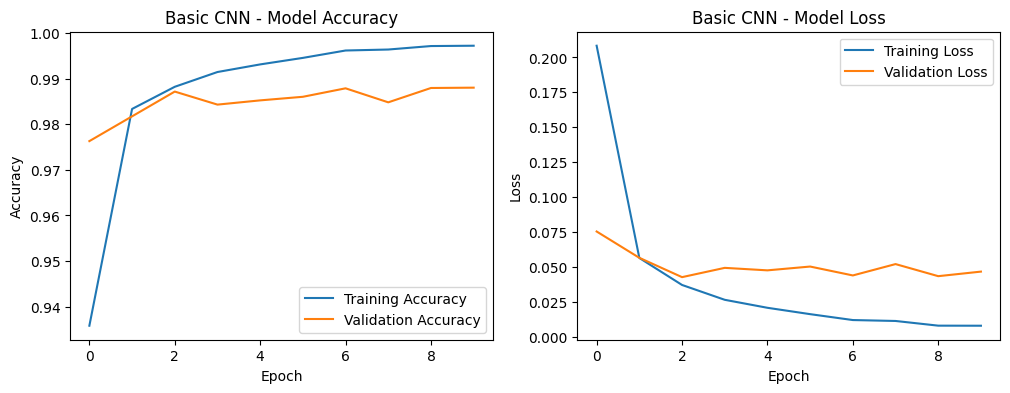

Evaluating Basic CNN on Test Set...


Test Loss: 0.0505 | Test Accuracy: 98.91%
----------------------------



In [27]:
class BasicCNN(nn.Module):
    def __init__(self):
        super(BasicCNN, self).__init__()
        # Conv Block 1: 1 input channel, 32 output channels, 3x3 kernel
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        # Conv Block 2: 32 input channels, 64 output channels, 3x3 kernel
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # After two 2x2 pooling layers, a 28x28 image becomes 7x7.
        # Flattened size = 64 (channels) * 7 * 7 = 3136
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10) # 10 classes

    def forward(self, x):
        # x shape: [B, 1, 28, 28]
        x = self.pool(F.relu(self.conv1(x)))
        # x shape: [B, 32, 14, 14]
        x = self.pool(F.relu(self.conv2(x)))
        # x shape: [B, 64, 7, 7]
        
        # Flatten
        x = x.view(-1, 64 * 7 * 7) # Reshape to [B, 3136]
        
        # Fully-connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x) # Output logits
        
        return x

# --- Setup and Run ---
N_EPOCHS = 10
basic_cnn_model = BasicCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(basic_cnn_model.parameters(), lr=0.001)

run_training(
    "Basic CNN",
    basic_cnn_model,
    criterion,
    optimizer,
    N_EPOCHS
)

### 9. Part B: Adding Dropout to Combat Overfitting

This second model, `CNNWithDropout`, is an experiment to improve our first model. It is almost identical to `BasicCNN` *except* for the addition of a **Dropout layer**.

#### What is Dropout?

Dropout is a powerful **regularization technique** used to **prevent overfitting**.

* **Overfitting** is when a model "memorizes" the training data too well but fails to generalize to new, unseen data (like our validation and test sets). In our plots, this would look like the training accuracy soaring to 100% while the validation accuracy flattens or even drops.

* **How Dropout Works:** 

[Image of dropout neural network]
 During training, a Dropout layer *randomly "drops" (sets to zero)* a certain percentage of its input neurons at each step. In our case, `p=0.5` means it will randomly ignore 50% of the neurons from the previous layer.

* **The Benefit:** This forces the network to learn more robust features. It can't become over-reliant on any single neuron, so it's forced to learn redundant representations, which helps it generalize much better.

---

#### Code Changes

We only made two small changes to our model:

1.  **In `__init__`:**
    * `self.dropout = nn.Dropout(p=0.5)`: We create an instance of the Dropout layer. A rate of 50% (`p=0.5`) is a very common and effective starting point.

2.  **In `forward`:**
    * `x = self.dropout(x)`: We apply the dropout. We've placed it *after* the `relu` activation of our first fully-connected layer (`fc1`) and *before* the data goes to the final output layer (`fc2`). This is a common place to apply it in a CNN.

**Crucial Connection:** This dropout layer is **only** active during training. This is automatically handled by the `model.train()` and `model.eval()` commands we defined in our helper functions:
* When `model.train()` is called, the Dropout layer is **ON** and actively drops neurons.
* When `model.eval()` is called (for validation or testing), the Dropout layer is automatically **OFF** so the model can use its full, learned knowledge.

#### Setup and Run

The training setup is the same as before. We are simply creating an instance of this new `CNNWithDropout` model and passing it to our `run_training` function. We can now directly compare its results (especially the plots) to the `BasicCNN` to see if dropout helped reduce overfitting and improve our final test score.

--- Training CNN with Dropout ---


Epoch 1/10 | Train Acc: 89.92% | Val Acc: 97.25%


Epoch 2/10 | Train Acc: 96.60% | Val Acc: 98.10%


Epoch 3/10 | Train Acc: 97.52% | Val Acc: 98.48%


Epoch 4/10 | Train Acc: 98.05% | Val Acc: 98.53%


Epoch 5/10 | Train Acc: 98.25% | Val Acc: 98.54%


Epoch 6/10 | Train Acc: 98.46% | Val Acc: 98.97%


Epoch 7/10 | Train Acc: 98.62% | Val Acc: 98.76%


Epoch 8/10 | Train Acc: 98.71% | Val Acc: 98.90%


Epoch 9/10 | Train Acc: 98.90% | Val Acc: 98.95%


Epoch 10/10 | Train Acc: 98.99% | Val Acc: 98.93%


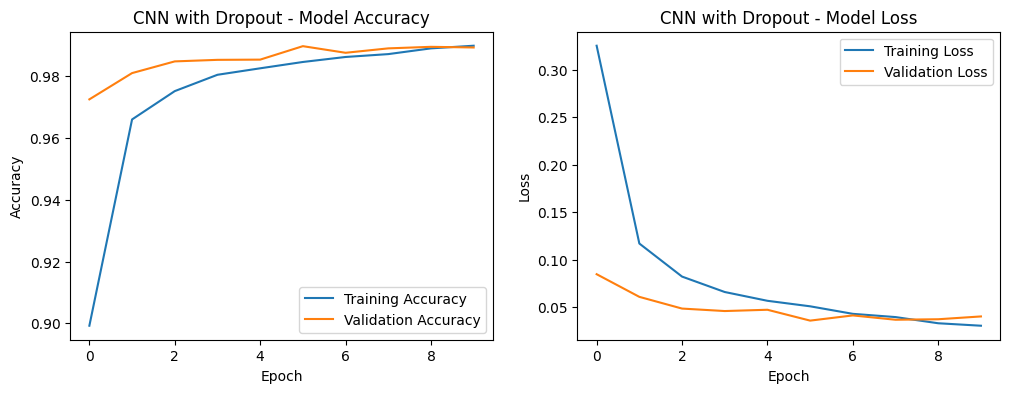

Evaluating CNN with Dropout on Test Set...


Test Loss: 0.0445 | Test Accuracy: 99.03%
----------------------------



In [28]:
class CNNWithDropout(nn.Module):
    def __init__(self):
        super(CNNWithDropout, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        
        # --- ADDED DROPOUT ---
        self.dropout = nn.Dropout(p=0.5) # 50% dropout
        
        self.fc2 = nn.Linear(128, 10) 

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        
        # --- APPLY DROPOUT ---
        # Apply dropout *before* the next layer
        x = self.dropout(x)
        
        x = self.fc2(x)
        return x

# --- Setup and Run ---
dropout_cnn_model = CNNWithDropout().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(dropout_cnn_model.parameters(), lr=0.001)

run_training(
    "CNN with Dropout",
    dropout_cnn_model,
    criterion,
    optimizer,
    N_EPOCHS
)

### 10. Part C: Adding Batch Normalization

This third model, `CNNWithBatchNorm`, introduces **Batch Normalization (BatchNorm)**. This is an extremely powerful technique that has become a standard part of most modern deep learning models.

#### What is Batch Normalization?

Batch Normalization is a layer that "normalizes" the output from the previous layer.  For every batch of data, it adjusts the output so that it has a **mean of 0** and a **standard deviation of 1**.

This has several major benefits:

* **Speeds up Training:** It makes the learning process much more stable. This allows us to use higher learning rates, which helps the model find a good solution (converge) much faster.
* **Stabilizes Learning:** It fixes a problem called "Internal Covariate Shift." In simple terms, this means that the data distribution that each layer sees is kept consistent. This makes it much easier for the model's layers to learn.
* **Acts as a Regularizer:** It has a slight regularization effect, which can sometimes reduce the need for (or be used in addition to) Dropout.

---

#### Code Changes

1.  **In `__init__` (The Constructor):**
    * `self.bn1 = nn.BatchNorm2d(num_features=32)`: We add a **2D** BatchNorm layer. It's "2D" because it's designed to work on 4D tensors `(Batch, Channel, Height, Width)`. The `num_features` **must** match the number of output channels from the previous `conv1` layer (which is 32).
    * `self.bn2 = nn.BatchNorm2d(num_features=64)`: Similarly, this one matches the 64 output channels of `conv2`.
    * `self.bn_fc1 = nn.BatchNorm1d(num_features=128)`: We add a **1D** BatchNorm layer. It's "1D" because it works on 2D tensors `(Batch, Features)`, which is what we have after flattening and passing through `fc1`. It matches the 128 output features of `fc1`.

2.  **In `forward` (The Data Flow):**
    * We change the order of operations. The new, highly effective pattern is:
        **`CONV -> BATCH NORM -> ReLU`**
    * First, the data goes through the convolutional layer (`self.conv1(x)`).
    * *Then*, the raw output is normalized by the BatchNorm layer (`self.bn1(x)`).
    * *Finally*, the normalized data is passed through the `F.relu` activation function.
    * We apply this same pattern to all three blocks: `conv1`, `conv2`, and `fc1`.

#### Training vs. Evaluation (Very Important!)

Just like Dropout, BatchNorm behaves differently during training and evaluation. This is automatically controlled by `model.train()` and `model.eval()`.

* **During Training (`model.train()`):** The layer calculates the mean and standard deviation of the **current batch**. It also keeps a "running average" of the mean and variance it has seen across all batches.
* **During Evaluation (`model.eval()`):** The layer **freezes**. It stops calculating from the batch and instead uses the stable "running average" it learned during all of training. This is crucial for getting consistent and accurate predictions.

Our `run_training` function already handles this for us, so no extra code is needed. We can now train this model and see how much faster it learns and how it performs compared to the first two.

In [29]:
class CNNWithBatchNorm(nn.Module):
    def __init__(self):
        super(CNNWithBatchNorm, self).__init__()
        
        # --- Conv Block 1 ---
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_features=32) # For 32 channels
        
        # --- Conv Block 2 ---
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(num_features=64) # For 64 channels
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # --- Dense Block ---
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.bn_fc1 = nn.BatchNorm1d(num_features=128) # For 128 features
        
        self.fc2 = nn.Linear(128, 10) 

    def forward(self, x):
        # Common pattern: Conv -> BatchNorm -> ReLU
        
        # Conv Block 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool(x)
        
        # Conv Block 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool(x)
        
        # Flatten
        x = x.view(-1, 64 * 7 * 7)
        
        # Dense Block
        x = self.fc1(x)
        x = self.bn_fc1(x)
        x = F.relu(x)
        
        x = self.fc2(x)
        return x

# --- Setup and Run ---
batchnorm_cnn_model = CNNWithBatchNorm().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(batchnorm_cnn_model.parameters(), lr=0.001)

run_training(
    "CNN with Batch Norm",
    batchnorm_cnn_model,
    criterion,
    optimizer,
    N_EPOCHS
)

--- Training CNN with Batch Norm ---


KeyboardInterrupt: 

### 11. Part D: Final Model Comparison

This is the final cell where we bring everything together. After training three different models, we now compare their final performance on the unseen **Test Set**.

* **`model_results` Dictionary:** This is the dictionary we created back in Cell 6. Our `run_training` function automatically added the final test accuracy for each model to this dictionary right after training was complete. It likely looks something like this:
    ```python
    {'Basic CNN': 0.988,
     'CNN with Dropout': 0.991,
     'CNN with Batch Norm': 0.992}
    ```

* **Printing the Results:** The `for` loop simply iterates through our dictionary and prints a clean, text-based summary of the final test accuracy for each model.

* **Creating the Bar Chart:** A visual comparison is often more impactful.  This code uses `matplotlib` to create a bar chart:
    1.  It extracts the model names (`.keys()`) and their accuracies (`.values()`) into two lists.
    2.  `plt.bar(...)`: It creates the bar chart, assigning a different color to each model for clarity.
    3.  `plt.ylim(...)`: It sets the y-axis limits to be very close to the actual accuracy values. This "zooms in" on the top of the bars, making small (but important) differences in performance much easier to see.
    4.  `plt.text(...)`: This loop adds the exact accuracy percentage (e.g., "99.20%") on top of each bar, making the chart easy to read at a glance.
    5.  `plt.show()`: This displays the final comparison chart.

This chart is our final report card, allowing us to definitively see which techniques (Dropout or Batch Norm) provided the biggest improvement over our baseline `BasicCNN` model.

--- Final Model Comparison (Test Accuracy) ---
Basic CNN: 98.85%
CNN with Dropout: 98.97%
CNN with Batch Norm: 98.74%


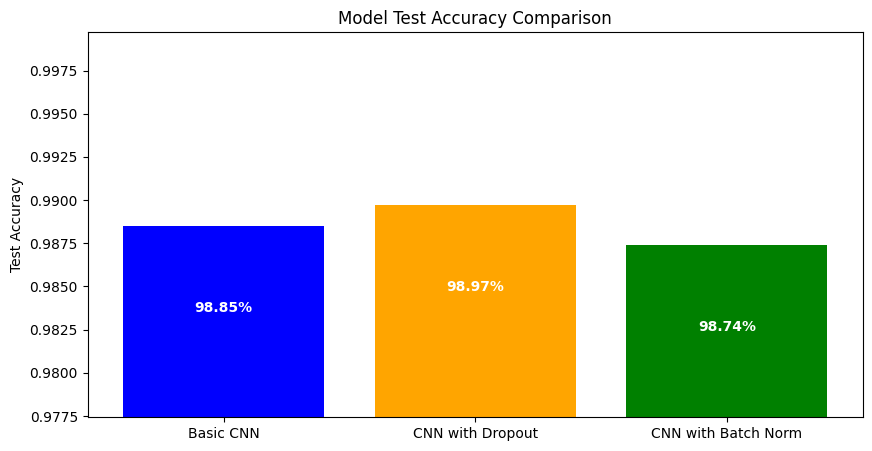

In [ ]:
print("--- Final Model Comparison (Test Accuracy) ---")
for model_name, acc in model_results.items():
    print(f"{model_name}: {acc*100:.2f}%")

# Create a bar chart for visual comparison
names = list(model_results.keys())
accuracies = list(model_results.values())

plt.figure(figsize=(10, 5))
plt.bar(names, accuracies, color=['blue', 'orange', 'green'])
plt.ylabel("Test Accuracy")
plt.title("Model Test Accuracy Comparison")
plt.ylim(min(accuracies) - 0.01, max(accuracies) + 0.01) # Set Y-limit
for i, v in enumerate(accuracies):
    plt.text(i, v - 0.005, f"{v*100:.2f}%", ha='center', color='white', fontweight='bold')
plt.show()

In [ ]:
# --- 1. Save the PyTorch Model ---
# We'll save the 'state dictionary' (the weights) of our best model.
MODEL_SAVE_PATH = "digits_model_pytorch.pth"

# Make sure the model is on the CPU before saving
# This makes it easier to load on any machine
batchnorm_cnn_model.to("cpu")
torch.save(batchnorm_cnn_model.state_dict(), MODEL_SAVE_PATH)

print(f"Model saved to {MODEL_SAVE_PATH}")

Model saved to digits_model_pytorch.pth


In [ ]:
# --- 2. Build the Gradio App ---
# Make sure to run: 
import gradio as gr
from PIL import Image, ImageOps
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import transforms

# --- A. Load the PyTorch Model ---
# We must first re-define the class, just as we did for training
class CNNWithBatchNorm(nn.Module):
    def __init__(self):
        super(CNNWithBatchNorm, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        
        # This calculation might be slightly different if padding was used
        # Let's re-calculate based on our previous model
        # 28x28 -> conv1 (no pad) -> 26x26 -> pool -> 13x13
        # 13x13 -> conv2 (no pad) -> 11x11 -> pool -> 5x5
        # So flattened size is 64 * 5 * 5 = 1600.
        # Let's adjust the class to match the one we trained!
        
        # --- Re-using the EXACT trained class definition ---
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_features=32) 
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(num_features=64) 
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # 28x28 -> pool -> 14x14 -> pool -> 7x7
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.bn_fc1 = nn.BatchNorm1d(num_features=128)
        self.fc2 = nn.Linear(128, 10) 

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 64 * 7 * 7) # Flatten
        x = F.relu(self.bn_fc1(self.fc1(x)))
        x = self.fc2(x)
        return x
        
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the model and weights
MODEL_SAVE_PATH = "digits_model_pytorch.pth"
pytorch_model = CNNWithBatchNorm().to(device)
pytorch_model.load_state_dict(torch.load(MODEL_SAVE_PATH))
pytorch_model.eval() # Set model to evaluation mode (turns off dropout/batchnorm updates)
print("PyTorch model loaded successfully.")

# Define the transform to match our training (converts PIL to [1, 28, 28] tensor)
# ToTensor() automatically scales [0, 255] PIL image to [0.0, 1.0] tensor
preprocess_transform = transforms.ToTensor()


# --- B. Function to predict the digit (PyTorch version) ---
def predict_digit_pytorch(sketchpad):
    if sketchpad is not None:
        # Extract sketchpad data and convert to PIL Image
        image_data = sketchpad['composite']
        pil_image = Image.fromarray(image_data)

        # Fill transparent background with white (same as your code)
        if pil_image.mode == "RGBA":
            white_background = Image.new("RGBA", pil_image.size, (255, 255, 255, 255))
            pil_image = Image.alpha_composite(white_background, pil_image)
            pil_image = pil_image.convert("RGB") # Remove alpha

        # Convert to grayscale
        grayscale_image = pil_image.convert("L")
        
        # --- Preprocessing for MNIST ---
        # 1. Invert colors (MNIST is white-on-black, drawing is black-on-white)
        img = ImageOps.invert(grayscale_image)
        # 2. Resize to 28x28
        img = img.resize((28, 28))
        
        # --- 3. Convert to PyTorch Tensor (DIFFERENT from Keras) ---
        # ToTensor() converts PIL [0, 255] to PyTorch [0.0, 1.0]
        # and changes shape from (H, W) to (C, H, W) -> [1, 28, 28]
        img_tensor = preprocess_transform(img)
        
        # 4. Add Batch dimension -> [1, 1, 28, 28]
        # This is the shape our PyTorch model expects
        img_tensor = img_tensor.unsqueeze(0)
        
        # 5. Move tensor to the correct device
        img_tensor = img_tensor.to(device)

        # --- C. Get model prediction (PyTorch version) ---
        with torch.no_grad(): # Turn off gradients for inference
            output = pytorch_model(img_tensor)
            
        # Get the digit with the highest probability (logit)
        _, predicted = torch.max(output.data, 1)
        predicted_digit = predicted.item() # .item() gets the Python number from the tensor

        return f"Predicted Digit: {predicted_digit}"

# --- D. Create the Gradio interface ---
gr.Interface(
    fn=predict_digit_pytorch,
    inputs="sketchpad",
    outputs="text",
    title="PyTorch MNIST Digit Recognizer",
    description="Draw a digit (0-9) on the sketchpad and click 'Submit' to see the model's prediction."
).launch(debug=True)

PyTorch model loaded successfully.
* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


Keyboard interruption in main thread... closing server.
